# Develope Numeric z-cross-spectrum 

In [1]:
using Polynomials
using LinearAlgebra
using DSP
using Plots
using FFTW
pyplot()

include("SFbyCKMS_Matrix.jl")

Nex = 2^10;
Theta = 2pi*(0:Nex-1)/(Nex-1);
Z = map(th -> exp(im*th),Theta);

In [2]:
function z_crossspect(X,Y,L = 50, Nex = 2^10; win = "Par")
    ## Y = d x 1 x steps, X = nu x 1 x steps
    d, stepsx = size(X)
    nu, stepsy = size(Y)

    Nexh = Int(floor(Nex/2))
    lags = -L:L;

    stepsx == stepsy || print("X and Y are not the same length. Taking min.")
    steps = minimum([stepsx stepsy])

    # Smoothed viewing window
    if win == "Bar"
        lam = 1 .- (0:L)/L
    elseif win == "Tuk"
        lam = .5*(1 .+ cos.(pi/L*(0:L)))
    elseif win == "Par"
        LL = Int(floor(L/2))
        lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
        lam2 = 2*(1 .- (LL+1:L)/L).^3
        lam = [lam1; lam2]
    else
        lam = ones(L+1)
    end
    Lam = [lam[L+1:-1:2]; lam]

    C_smoothed = zeros(d,nu,length(lags))
    for i = 1 : d
        for j = 1 : nu
            C_smoothed[i,j,:] = Lam .* crosscov(X[i,1:steps],Y[j,1:steps],lags)
        end
    end

    ## C_smoothed = d x nu x 2L+1

    ## Pad with zeros in preparation for fft
    C_padded = cat(dims = 3, zeros(d,nu,Nex - Nexh - L), C_smoothed, zeros(d,nu,Nexh - L - 1))
    C = fftshift(C_padded,3)

    z_crossspect_num_fft = fft(C,3);
end

z_crossspect (generic function with 3 methods)

### Generate Time series

Start with AR(1) process.

In [3]:
p = 1
c = [-1 2;.9 8]/9
# Test for stability and stationarity
all(abs.(eigvals(c)) .< 1) || error("matrix coefficent genarates unstable VAR process");

sig_v = [1 0; 0 1];


steps = 1*10^6
discard = 10^3
steps_tot = steps + discard

noise_sig = randn(2,steps_tot)
sig = zeros(2,steps_tot);

sig[:,1:2] = noise_sig[:,1:2]

for i = p+1 : steps_tot
    sig[:,i] = c*sig[:,i-p] + noise_sig[:,i]
end

sig = sig[:,discard + 1 : steps_tot];

noise_pred = sig_v*randn(2,steps)
pred = sig .+ noise_pred;

In [4]:
z_crossspect_num_fft = z_crossspect(sig,pred);

## Analytic Solution
# (Done in wxMaxima) for c = [-1 2;.9 8]/9

function z_crossspect_ana(z) 
    A = complex(zeros(2,2))
    
    A[1,1] = (145800*z^3-301725*z^2+145800*z)/(19845*z^4+112140*z^3-265651*z^2+112140*z+19845)
    A[1,2] = -(32805*z^3-21060*z^2+72900*z)/(39690*z^4+224280*z^3-531302*z^2+224280*z+39690)
    A[2,1] = -(72900*z^3-21060*z^2+32805*z)/(39690*z^4+224280*z^3-531302*z^2+224280*z+39690) 
    A[2,2] = -(72900*z^3+670761*z^2+72900*z)/(79380*z^4+448560*z^3-1062604*z^2+448560*z+79380)
    
    A
end

z_crossspect_ana (generic function with 1 method)

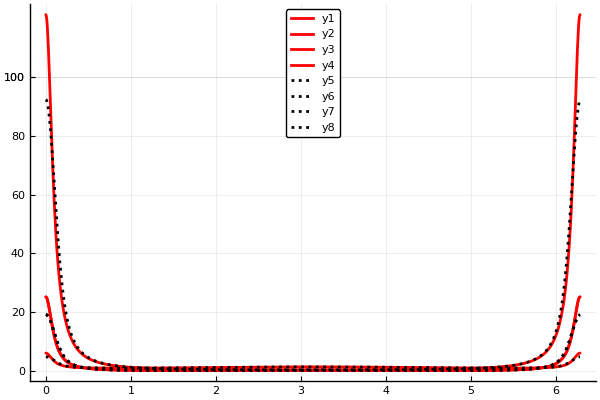

In [5]:
### Plot
S_ana = complex(zeros(2,2,Nex))
for i = 1:Nex
    S_ana[:,:,i] = z_crossspect_ana(Z[i])
end

Y1 = transpose(reshape(S_ana,4,Nex));
Y2 = transpose(reshape(z_crossspect_num_fft,4,Nex));
Y = [Y1 Y2];

plot(Theta, abs.(Y),
    color =[:red :red :red :red :black :black :black :black],
    line = (2,[:solid :solid :solid :solid :dot :dot :dot :dot])
    )

Now with MA(1) process.

In [6]:
p = 1
c = [-1 2;.9 8]

sig_v = [1 0; 0 1];


steps = 1*10^6
discard = 10^3
steps_tot = steps + discard

noise_sig = randn(2,steps_tot)
sig = zeros(2,steps_tot);

sig[:,1:2] = noise_sig[:,1:2]

for i = p+1 : steps_tot
    sig[:,i] = noise_sig[:,i] - c*noise_sig[:,i-p] 
end

sig = sig[:,discard + 1 : steps_tot];

noise_pred = sig_v*randn(2,steps)
pred = sig .+ noise_pred;

In [7]:
z_crossspect_num_fft = z_crossspect(sig,pred);

## Analytic Solution
# (Done in wxMaxima) for c = [-1 2;.9 8]/9

function z_crossspect_ana(z) 
    A = complex(zeros(2,2))
        
    A[1,1] = (z^2+6*z+1)/z
    A[1,2] = -(9*z^2-151*z+20)/(10*z)
    A[2,1] = -(20*z^2-151*z+9)/(10*z) 
    A[2,2] = -(800*z^2-6581*z+800)/(100*z)
    
    A
end

z_crossspect_ana (generic function with 1 method)

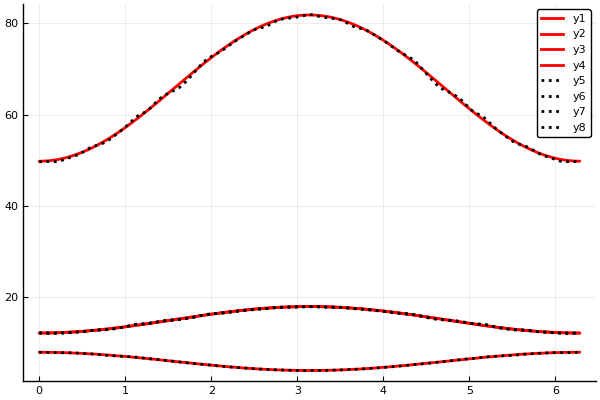

In [8]:
### Plot
S_ana = complex(zeros(2,2,Nex))
for i = 1:Nex
    S_ana[:,:,i] = z_crossspect_ana(Z[i])
end

Y1 = transpose(reshape(S_ana,4,Nex));
Y2 = transpose(reshape(z_crossspect_num_fft,4,Nex));
Y = [Y1 Y2];

plot(Theta, abs.(Y),
    color =[:red :red :red :red :black :black :black :black],
    line = (2,[:solid :solid :solid :solid :dot :dot :dot :dot])
    )